## Call the import statements

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers

import matplotlib.pyplot as plt

In [3]:
pd.options.display.max_rows=10
pd.options.display.float_format = '{:.1f}'.format

In [4]:
tf.keras.backend.set_floatx('float32') # set defaults float type

## Load, scale, and shuffle the examples

In [5]:
# Load the dataset
train_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
test_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")

In [6]:
train_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.3,34.2,15.0,5612.0,1283.0,1015.0,472.0,1.5,66900.0
1,-114.5,34.4,19.0,7650.0,1901.0,1129.0,463.0,1.8,80100.0
2,-114.6,33.7,17.0,720.0,174.0,333.0,117.0,1.7,85700.0
3,-114.6,33.6,14.0,1501.0,337.0,515.0,226.0,3.2,73400.0
4,-114.6,33.6,20.0,1454.0,326.0,624.0,262.0,1.9,65500.0


In [7]:
scale_factor = 1000
train_df['median_house_value'] = train_df['median_house_value'] / scale_factor
test_df['median_house_value'] /= scale_factor

In [8]:
train_df = train_df.sample(frac=1) # or
train_df = train_df.reindex(np.random.permutation(train_df.index))

## Represent latitude and longitude as floating-point values

In [10]:
# Create an empty list that will eventually hold all feature columns.
feature_columns = []

In [12]:
# Create a numerical feature column to represent latitude.
latitude = tf.feature_column.numeric_column('latitude')
feature_columns.append(latitude)

In [19]:
# Create a numerical feature column to represent longitude.
longitude = tf.feature_column.numeric_column('longitude')
feature_columns.append(longitude)

In [20]:
len(feature_columns)

2

In [21]:
# Convert the list of feature columns into a layer that will ultimately become
# part of the model. Understanding layers is not important right now.
fp_feature_layer = layers.DenseFeatures(feature_columns)

In [24]:
fp_feature_layer

## Define functions that create and train a model, and a plotting function

In [25]:
def create_model(my_learning_rate, feature_layer):
    model = tf.keras.models.Sequential()
    # Add the layer containing the feature columns to the model.
    model.add(feature_layer)
    # Add one linear layer to the model to yield a simple linear regressor.
    model.add(tf.keras.layers.Dense(units=1, input_shape=(1,)))
    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=my_learning_rate),
                 loss='mean_squared_error',
                 metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

In [29]:
def train_model(model, dataset, epochs, batch_size, label_name):
    features = {name:np.array(value) for name, value in dataset.items()}
    label = np.array(features.pop(label_name))
    history = model.fit(x=features, y=label, batch_size=batch_size,
                       epochs=epochs, shuffle=True)
    
    # The list of epochs is stored separately from the rest of history.
    epochs = history.epoch
    
    # Isolate the mean absolute error for each epoch.
    hist = pd.DataFrame(history.history)
    rmse = hist['root_mean_squared_error']
    
    return epochs, rmse

In [27]:
def plot_the_loss_curve(epochs, rmse):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Root Mean Squared Error')
    
    plt.plot(epochs, rmse, label='Loss')
    plt.legend()
    plt.ylim([rmse.min()*0.94, rmse.max()*1.05])
    plt.show()
    
print('Defined the create_model, train_model, and plot_the_loss-curve functions')

Defined the create_model, train_model, and plot_the_loss-curve functions


## Train the model with floating-point representations

Epoch 1/30
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
170/170 [==============================] - 1s 3ms/step - loss: 18272.8867 - root_mean_squared_error: 135.1772
Epoch 2/30
170/170 [==============================] - 0s 2ms/step - loss: 13612.1338 - root_mean_squared_error: 116.6711
Epoch 3/30
170/170 [==============================] - 0s 2ms/step - loss: 13567.7998 - root_mean_squared_error: 116.4809
Epoch 4/30
170/170 [==============================] - 0s 3ms/step - loss: 13493.9834 - root_mean_squared_error: 116.1636
Epoch 5/30
170/170 [==============================] - 0s 2ms/step - loss: 13464.9736 - root_mean_squared_error: 116.0387
Epoch 6/30
170/170 [==============================] - 0s 3ms/step - loss: 13421.2822 - root_mean_squared_error: 115.8503
Epoch 7/30
170/170 [==============================] - 0s 2ms/step - loss: 13365.8311 - root_mean_squared_error: 115.6107
Epoch 8/30
170/170 [=======================

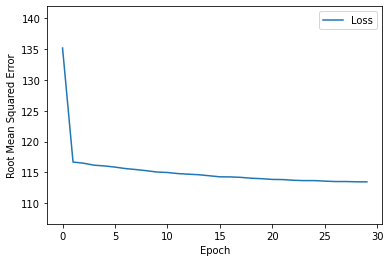


: Evaluate the new model against the test set:
Consider rewriting this model with the Functional API.
30/30 [==============================] - 0s 2ms/step - loss: 12188.1094 - root_mean_squared_error: 110.3998


[12188.109375, 110.39976501464844]

In [30]:
# The following variables are the hyperparameters.
learning_rate = 0.05
epochs = 30
batch_size = 100
label_name = 'median_house_value'

# Create and compile the model's topography.
my_model = create_model(learning_rate, fp_feature_layer)

# Train the model on the training set.
epochs, rmse = train_model(my_model, train_df, epochs, batch_size, label_name)

plot_the_loss_curve(epochs, rmse)

print('\n: Evaluate the new model against the test set:')
test_features = {name:np.array(value) for name, value in test_df.items()}
test_label = np.array(test_features.pop(label_name))
my_model.evaluate(x=test_features, y=test_label, batch_size=batch_size)